In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [2]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

### Reading the Dataset

In [3]:
df = (spark.read
          .format("csv")
          .option('header', 'true')
          .load("./datasets/uci-diabetes.csv"))

In [4]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline

### Selecting Features and Casting it into required Dtype

In [5]:
columns  = df.columns

dataset = df.select(col(columns[1]).cast('float'),
                    col(columns[2]).cast('float'),
                    col(columns[3]).cast('string'),
                    col(columns[4]).cast('float'),
                   )

### Feature Transformation

In [6]:
indexer = StringIndexer(inputCol="code", outputCol="codeIndex")
encoder = OneHotEncoder(inputCol="codeIndex", outputCol="codeVec")
vectorAssembler = VectorAssembler(inputCols=['value','codeVec'],
                                  outputCol="features")
#normalizer = Normalizer(inputCol="features", outputCol="features_norm", p=1.0)
scaler = StandardScaler(inputCol="features", outputCol="features_norm")
pipeline = Pipeline(stages=[indexer, encoder, vectorAssembler, scaler])
final_df = pipeline.fit(dataset).transform(dataset)

### Splitting dataset into training data and test data

In [7]:
(training_data, test_data) = final_df.randomSplit([0.8,0.2],seed=1234)

### Building Model

In [8]:
gbtc = GBTClassifier()
param_grid = (ParamGridBuilder()
              .baseOn({gbtc.labelCol : 'Class'})
              .baseOn([gbtc.predictionCol, 'pred_gbtc'])
              .baseOn([gbtc.featuresCol, 'features_norm'])
              .addGrid(gbtc.maxDepth, [2,3,5,7,10])
              .addGrid(gbtc.maxIter, [20,40,60,100,120]).build())

evaluator = BinaryClassificationEvaluator(labelCol= 'Class',rawPredictionCol= 'pred_gbtc')


cv = CrossValidator(estimator=gbtc, estimatorParamMaps=param_grid, evaluator=evaluator,seed=0,parallelism=2)

### Training the Model

In [9]:
cvModel= cv.fit(training_data)

In [10]:
cvModel.avgMetrics

[0.9994948776747266,
 0.9994948776747266,
 0.9994948776747266,
 0.9995016993396786,
 0.9995016993396786,
 0.9996900764706949,
 0.9996494656844701,
 0.9996494656844701,
 0.9996494656844701,
 0.9996494656844701,
 0.9996494656844701,
 0.9996494656844701,
 0.9996494656844701,
 0.9996494656844701,
 0.9996494656844701,
 0.9996494656844701,
 0.9996494656844701,
 0.9996900764706949,
 0.9996494656844701,
 0.9996494656844701,
 0.9996494656844701,
 0.9996494656844701,
 0.9996494656844701,
 0.9996494656844701,
 0.9996494656844701]

### Evaluating the Model using different evaluation metrices

In [11]:
evaluator.evaluate(cvModel.transform(test_data),{evaluator.metricName: 'areaUnderPR'})

0.9996925214342534

In [12]:
evaluator.evaluate(cvModel.transform(test_data), {evaluator.metricName: 'areaUnderROC'})

0.9993481095176011

### Best Params

In [13]:
cvModel.bestModel.getMaxDepth()

3

In [14]:
cvModel.bestModel.getMaxIter()

20

### Saving the Model

In [18]:
path= r'./SavedModel/gbtc_model'
cvModel.save(path)

### Loading the Trained Model

In [19]:
#gbtc_model= CrossValidatorModel.read().load(path)

### Result summary

In [15]:
import pandas as pd

summary_= {
    'areaUnderPR' : evaluator.evaluate(cvModel.transform(test_data),{evaluator.metricName: 'areaUnderPR'}),
    'areaUnderROC' :evaluator.evaluate(cvModel.transform(test_data), {evaluator.metricName: 'areaUnderROC'})
}
summary= pd.Series(summary_)
summary

areaUnderPR     0.999693
areaUnderROC    0.999348
dtype: float64

### Plotting Feature Importances

In [16]:
#Features used to train model

features=[
    'Value',
    'Regular insulin dose',
    'NPH insulin dose',
    'UltraLente insulin dose',
    'Unspecified blood glucose measurement',
    'Unspecified blood glucose measurement',
    'Pre-breakfast blood glucose measurement',
    'Post-breakfast blood glucose measurement',
    'Pre-lunch blood glucose measurement',
    'Post-lunch blood glucose measurement',
    'Pre-supper blood glucose measurement',
    'Post-supper blood glucose measurement',
    'Pre-snack blood glucose measurement',
    'Hypoglycemic symptoms',
    'Typical meal ingestion',
    'More-than-usual meal ingestion',
    'Less-than-usual meal ingestion',
    'Typical exercise activity',
    'More-than-usual meal ingestion'
]

#Coefficients of different features of trained model
featureImportances= cvModel.bestModel.featureImportances.toArray()

<AxesSubplot:title={'center':'FeatureImportance Curve'}, xlabel='Features', ylabel='FeatureImportances'>

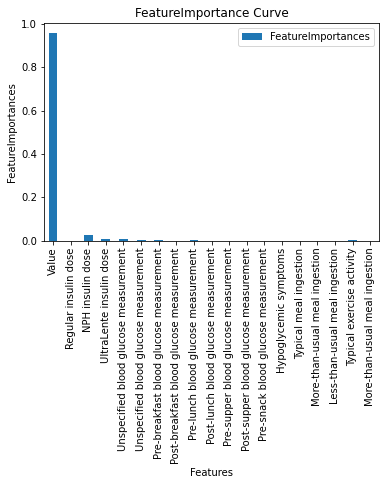

In [17]:
series = pd.Series(featureImportances,features)
df = pd.DataFrame(series,columns=['FeatureImportances'])
df.plot.bar(title='FeatureImportance Curve',ylabel='FeatureImportances',xlabel='Features')